In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams.update({'font.size': 16})
from DiscretizeTools import rouwenhorst, grow_grid
from scipy.optimize import root
from linear import LinintGrow
import time
import warnings
warnings.simplefilter('error', RuntimeWarning)

In [2]:
def initialize():
    global r, w,\
    J, JR,\
    ψ, eff,\
    pen,\
    NP, σθ, θ, dist_θ,\
    NS, ρ, σϵ, η, π, is_initial,\
    NA, al, au, agrow, a, a_bor, abor_temp,\
    γ, egam, β,\
    ϕ
    
    # parameters
    γ = 0.5
    egam = 1 - 1/γ
    β = 0.98
    
    # exogenous prices
    r = 0.04
    w = 1.0
    
    # Largest life span J and retir age JR
    J  = 80
    JR = 45
    
    # set survival probabilities, length = J + 1
    ψ = np.array([1.00000, 0.99923, 0.99914, 0.99914, 0.99912, \
                0.99906, 0.99908, 0.99906, 0.99907, 0.99901, \
                0.99899, 0.99896, 0.99893, 0.99890, 0.99887, \
                0.99886, 0.99878, 0.99871, 0.99862, 0.99853, \
                0.99841, 0.99835, 0.99819, 0.99801, 0.99785, \
                0.99757, 0.99735, 0.99701, 0.99676, 0.99650, \
                0.99614, 0.99581, 0.99555, 0.99503, 0.99471, \
                0.99435, 0.99393, 0.99343, 0.99294, 0.99237, \
                0.99190, 0.99137, 0.99085, 0.99000, 0.98871, \
                0.98871, 0.98721, 0.98612, 0.98462, 0.98376, \
                0.98226, 0.98062, 0.97908, 0.97682, 0.97514, \
                0.97250, 0.96925, 0.96710, 0.96330, 0.95965, \
                0.95619, 0.95115, 0.94677, 0.93987, 0.93445, \
                0.92717, 0.91872, 0.91006, 0.90036, 0.88744, \
                0.87539, 0.85936, 0.84996, 0.82889, 0.81469, \
                0.79705, 0.78081, 0.76174, 0.74195, 0.72155, \
                0.00000])

    # initialize age earnings process
    eff = np.zeros(J)
    eff[:JR-1] = np.array([1.0000, 1.0719, 1.1438, 1.2158, 1.2842, 1.3527, \
                        1.4212, 1.4897, 1.5582, 1.6267, 1.6952, 1.7217, \
                        1.7438, 1.7748, 1.8014, 1.8279, 1.8545, 1.8810, \
                        1.9075, 1.9341, 1.9606, 1.9623, 1.9640, 1.9658, \
                        1.9675, 1.9692, 1.9709, 1.9726, 1.9743, 1.9760, \
                        1.9777, 1.9700, 1.9623, 1.9546, 1.9469, 1.9392, \
                        1.9315, 1.9238, 1.9161, 1.9084, 1.9007, 1.8354, \
                        1.7701, 1.7048])

    # old-age transfers
    pen = np.zeros(J)
    pen[JR-1:] = 0.5 * w * sum(eff)/(JR-1)
    
    
    # initialize fixed effect
    NP = 2 # The number of the persistent shock process values
    σθ = 0.242
    dist_θ = 1/NP # assign equally probabilities to each possible persistent shock θ
    θ = np.zeros(NP)
    θ[0] = np.exp(-σθ**0.5)
    θ[1] = np.exp( σθ**0.5)
    
    # calculate the shock process
    NS = 7
    ρ = 0.985
    σϵ = 0.022**0.5
    η, π = rouwenhorst(ρ, σϵ, NS)
    η = np.exp(η)
    is_initial = int((NS + 1) / 2) - 1
    
    
    # initialize asset grid
    NA = 201
    al = 0
    au = 600
    agrow = 0.05
    a = grow_grid(al,au,agrow,NA)
    
    a_bor = np.zeros((J,NP)) 
    
    for j in range(J):
        for p in range(NP):
            # natural borrowing limit
            abor_temp = 0
            for jj in range(j + 1, J): 
                abor_temp += (w * eff[jj] * θ[p] * η[0] + pen[jj])/(1+r)**(jj - j)
 
            abor_temp = min(-abor_temp + 1e-4, 0)
            
            a_bor[j,p] = max(a_bor[j,p], abor_temp)
    
    ϕ = np.zeros((J, NA, NP, NS))



In [3]:
def solve_household():
    global aplus, c, V, RHS, EV, ip_max, is_max, x_in, wage, available, cons_com, ij_com, ia_com, ip_com, is_com
    
    aplus = np.zeros((J,NA,NP,NS)) # 4 state variables
    c = np.zeros((J,NA,NP,NS))
    V = np.zeros((J,NA,NP,NS))
    
    RHS = np.zeros((J,NA,NP,NS))
    EV = np.zeros((J,NA,NP,NS))
    
    # decisions in the last period (J period)
    
    for i in range(NA):
        aplus[-1,i,:,:] = 0.0 # leave nothing in the last period, independent of the 
                               #asset position and productivity chracterisation
        c[-1,i,:,:] = (1 + r) * (a[i] + a_bor[-1,0]) + pen[-1]
        V[-1,i,:,:] = valuefun(0, c[-1,i,0,0], J-1, 0, 0 )
        # valuefun(aplus, consumption, j, p, s)

    # interpolate individual RHS
    
    interpolate(J-1)
    
    for j in range(J-2, -1, -1):
        
        # check about how many is to iterate
        
        if j >= JR - 1:
            ip_max = 1
            is_max = 1
        else:
            ip_max = NP
            is_max = NS
            
        
        for i in range(NA):
            # determine decision for zero assets at retirement without pension
            if j >= JR - 1 and i == 0 and pen[j] <= 1e-10:
                aplus[j,i,:,:] = 0
                c[j,i,:,:] = 0
                V[j,i,:,:] = valuefun(0,0,j,0,0)
            
            # solve the household porblem using rootfinding method (x_in here is the next period asset)
            for p in range(ip_max):
                for s in range(is_max):
                    
                    # set up conmunication variables
                    ij_com = j
                    ia_com = i
                    ip_com = p
                    is_com = s
                    
                    # initial guess for the indicisual choices 
                    guess = aplus[j+1,i, p, s]
                    x_in = root(foc, x0=guess).x[0]
                    
                    # check for borrowing constraint manually
                    if x_in < 0:
                        x_in = 0
                        wage = w*eff[j]*θ[p]*η[s]
                        available = (1+r)*(a[i] + a_bor[j,p]) + wage + pen[j]
                        cons_com = available - a_bor[j+1,p] ## other 'cons_com' is defined in the foc fucntion
                    # copy decisions
                    aplus[j,i,p,s] = x_in
                    c[j,i,p,s] = cons_com
                    V[j,i,p,s] = valuefun(x_in,cons_com,j,p,s)
                    
            # copy decision in retirment age
            if j >= JR - 1: # if agent is in their retirment age (JR - 1 because the index system of python)
                aplus[j,i,:,:] = aplus[j,i,0,0]
                c[j,i,:,:] = c[j,i,0,0]
                V[j,i,:,:] = V[j,i,0,0]
                    
        # interpolate individual RHS
        interpolate(j)
    
    

In [4]:
def interpolate(j):
    global RHS, EV
    
    for i in range(NA):
        for p in range(NP):
            for s in range(NS):
                # calculate the RHS of the first order condition
                
                RHS[j,i,p,s] = 0.0
                EV[j,i,p,s] = 0.0
                
                margu = np.maximum(c[j,i,p,:],1e-10)
                margu = margu**(-1/γ)

                RHS[j,i,p,s] = (β * ψ[j] * (1+r) * (π[s,:] @ margu))**(-γ)
                EV[j,i,p,s] = (egam* (π[s,:] @V[j,i,p,:]))**(1/egam)


In [5]:
def foc(x_in):
    global cons_com
    
    # calculate tomorrow's assets
    a_plus = x_in
    
    # calcualte the wage rate
    wage = w*eff[ij_com]*θ[ip_com]*η[is_com]
    
    # calculate available resources
    available = (1+r)*(a[ia_com] + a_bor[ij_com,ip_com]) + wage + pen[ij_com]
    
    # calculate consumption
    
    cons_com = available - (a_plus + a_bor[ij_com+1, ip_com])
    
    # calculate linear interpolation for future part of foc
    
    il, ir, φ0 = LinintGrow(a_plus, al, au,  agrow, NA)
    
    tomorrow = φ0*RHS[ij_com+1, il, ip_com, is_com] + (1-φ0)*RHS[ij_com+1, ir, ip_com, is_com]
    
    foc = cons_com - tomorrow
    
    return foc



In [6]:
def valuefun(a_plus, cons, j, p, s):
    
    # check whether consumption or leisure are too samll
    c_help = max(cons, 1e-10)
    
    # get tomorrow's utility
    il, ir, φ3 = LinintGrow(a_plus, al, au, agrow, NA)
    
    # calculate tomorrows's part of the value function
    valuefunc = 0.0
    if j < J - 1:
        valuefunc = max(φ3*EV[j+1, il, p, s] + (1-φ3)*EV[j+1, ir, p, s], 1e-10)**egam/egam
    ## note: the logic here is that, we calculate the age space (J, J-1, J-2,..,1,0) backwards.
    ## so the backwards enables us to have the value of EV[j+1]
    
    # add today's part and discount
    valuefunc = c_help**egam/egam + β*ψ[j + 1]*valuefunc
    
    return valuefunc



In [17]:
def distribution():
    global ϕ
    
    ϕ = np.zeros((J,NA,NP,NS))
    # get initial distribution of age 1 (index 0)
    for p in range(NP):
        il, ir, φ1 = LinintGrow(-a_bor[0,p], al, au, agrow, NA)
        ϕ[0,il,p,is_initial] = φ1*dist_θ
        ϕ[0,ir,p,is_initial] = (1-φ1)*(1-dist_θ)
        
    # successively compute distribution over ages
    for j in range(1,J):
        
        # iterate over yesterdays gridpoints
        for i in range(NA):
            for p in range(NP):
                for s in range(NS):
                    
                    #interpolate yesterday;s savings decision
                    il, ir, φ2 = LinintGrow(aplus[j-1,i,p,s], al, au, agrow, NA)                    
                    # restrict values to grid just in case
                    il = min(il, NA)
                    ir = min(ir, NA)
                    φ2 = min(φ2, 1)
                    
                    ϕ[j, il, p, :] += π[s,:] * φ2* ϕ[j-1,i,p,s]
                    ϕ[j, ir, p, :] += π[s,:] * (1-φ2)* ϕ[j-1,i,p,s]
                    

In [18]:
def aggregation():
    global c_coh, y_coh, a_coh, v_coh, cv_c, cv_y
    
    c_coh = np.zeros(J)
    y_coh = np.zeros(J)
    a_coh = np.zeros(J)
    v_coh = np.zeros(J)
    cv_c = np.zeros(J)
    cv_y = np.zeros(J)
    
    
    
    for j in range(J):
        for i in range(NA):
            for p in range(NP):
                for s in range(NS):
                    c_coh[j] += c[j,i,p,s]*ϕ[j,i,p,s]
                    y_coh[j] += eff[j]*θ[p]*η[s]*ϕ[j,i,p,s]
                    a_coh[j] += (a[i]+a_bor[j,p])*ϕ[j,i,p,s]
                    v_coh[j] += V[j,i,p,s]*ϕ[j,i,p,s]
                     
    # calculate cohort specific coefficients of variation
    for j in range(J):
        for i in range(NA):
            for p in range(NP):
                for s in range(NS):
                    cv_c[j] += (c[j,i,p,s] - c_coh[j])**2*ϕ[j,i,p,s]
                    cv_y[j] += (eff[j]*θ[p]*η[s] - y_coh[j])**2*ϕ[j,i,p,s]
                    
    cv_c = cv_c**0.5/c_coh
    cv_y = cv_y**0.5/np.maximum(y_coh, 1e-10)


In [19]:
%%time
initialize()
solve_household()
distribution()
aggregation()


CPU times: total: 26.5 s
Wall time: 26.5 s


(0.0, 1.0)

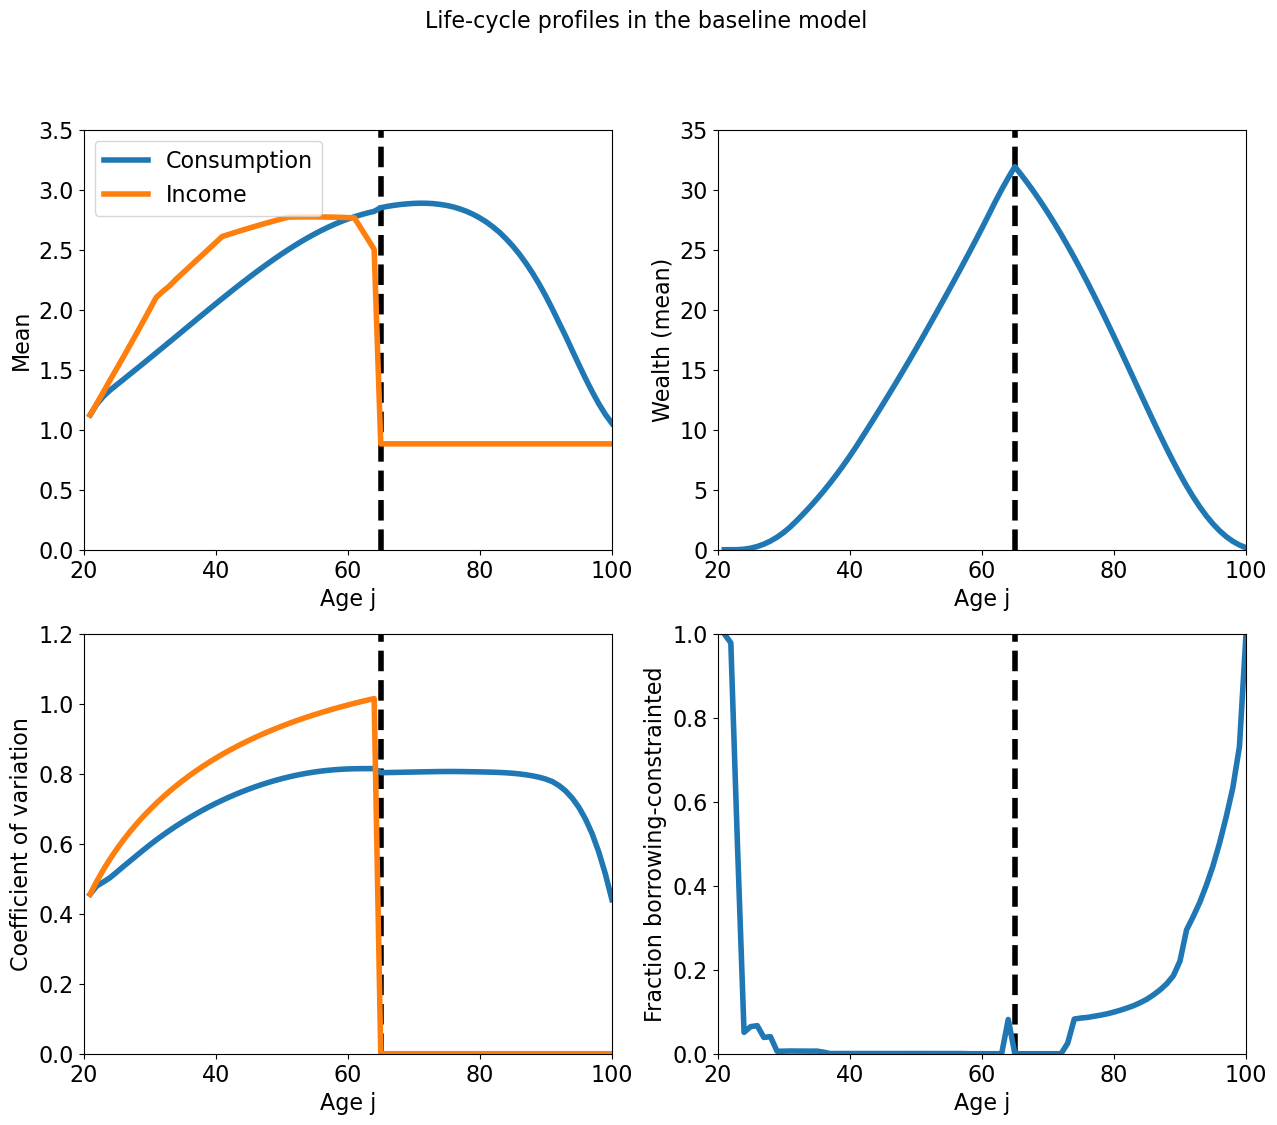

In [20]:
fig, ax = plt.subplots(2,2,figsize = (15,12))
fig.suptitle('Life-cycle profiles in the baseline model',fontsize = '16')
for i in range(2):
    for j in range(2):
        ax[i,j].axvline(x = 65, c = 'k', linestyle = '--')
        ax[i,j].set_xlim(20,100)
        ax[i,j].set_xlabel('Age j')

ax[0,0].plot(np.arange(J)+21, c_coh, label = 'Consumption')
ax[0,0].plot(np.arange(J)+21, y_coh+pen, label = 'Income')
ax[0,0].set_ylabel('Mean',fontsize = '16')
ax[0,0].legend()
ax[0,0].set_ylim(0,3.5)

ax[0,1].plot(np.arange(J)+21, a_coh)
ax[0,1].set_ylabel('Wealth (mean)',fontsize = '16')
ax[0,1].set_ylim(0,35)

ax[1,0].plot(np.arange(J)+21,cv_c)
ax[1,0].plot(np.arange(J)+21,cv_y)
ax[1,0].set_ylabel('Coefficient of variation', fontsize = '16')
ax[1,0].set_ylim(0,1.2)

frac_bor = np.zeros(J)
for j in range(J-1):
    for i in range(NA):
        for p in range(NP):
            for s in range(NS):
                if aplus[j,i,p,s] < 1e-6:
                    frac_bor[j] += ϕ[j,i,p,s]
frac_bor[-1] = 1
                    
ax[1,1].plot(np.arange(J)+21, frac_bor)
ax[1,1].set_ylabel('Fraction borrowing-constrainted', fontsize = '16')
ax[1,1].set_ylim(0,1)